# Dependencies

In [ ]:
import sys
!{sys.executable} -m pip install pip install pandas
!{sys.executable} -m pip install pip cache purge
!{sys.executable} -m pip install pip install networkx
!{sys.executable} -m spacy download en_core_web_sm
!{sys.executable} -m pip install pip install transformers torch
!{sys.executable} -m pip install pip install sentence-transformers

# Fetch Scraped Investopedia Data

In [42]:
import pandas as pd

In [43]:
df = pd.read_csv('investopediaScrapper.csv')
df.head()

,Term,Definition,URL
0,"10-K: Definition, What's Included, Instruction...",A 10-K is a comprehensive report filed annuall...,https://www.investopedia.com/terms/1/10-k.asp
1,"10-K Wrap: What It Is, How It Works, Elements",A 10-K wrap is part of a larger annual perform...,https://www.investopedia.com/terms/1/10k-wrap.asp
2,10-Year US Treasury Note: What It Is and Inves...,Treasury notes (T-notes) have maturities of up...,https://www.investopedia.com/terms/1/10-yeartr...
3,What Does 1%/10 Net 30 Mean in a Bill's Paymen...,A 1%/10 net 30 deal is when a 1% discount is o...,https://www.investopedia.com/terms/1/1-10net30...
4,"0x Protocol: What it Means, How it Works, Goals",The 0x protocol is an open protocol that enabl...,https://www.investopedia.com/terms/1/0x-protoc...


# Select Topic

In [44]:
topic = input('Enter the Topic for Knowledge Graph: ')
print(f"Entered title %s - ",topic)

Entered title %s -  Equities


In [45]:
df = df[(df['Term'].str.contains(topic, case=False)) | (df['Definition'].str.contains(topic, case=False))]
df.head()

,Term,Definition,URL
7,"100% Equities Strategy: What it Means, How it ...",A 100% equities strategy involves only long po...,https://www.investopedia.com/terms/1/100-equit...
271,What Is Asset Allocation and Why Is It Important?,Asset allocation is how investors split up the...,https://www.investopedia.com/terms/a/assetallo...
277,What Are Asset Classes? More Than Just Stocks ...,An asset class is a grouping of investments th...,https://www.investopedia.com/terms/a/assetclas...
428,Bear Traps: What They Are and How to Avoid The...,A bear trap is a false technical indication of...,https://www.investopedia.com/terms/b/beartrap.asp
505,What Is the Bombay Stock Exchange (BSE)?,Established in 1875 as the Native Share and St...,https://www.investopedia.com/terms/b/bombaysto...


In [46]:
df['Term'] = df['Term'].str.split(':').str[0]
df['Term'] = df['Term'].str.split('?').str[0]
df.size

111

# Uncovering Relationships with LLM Models

In [47]:
import pandas as pd
from transformers import pipeline

In [48]:
nli_pipeline = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')
qa_pipeline = pipeline('question-answering', model='distilbert-base-cased-distilled-squad')

def extract_relationships(term, definition):
    try:
        isrelated_statement = f"The definition '{definition}' is related to the term '{term}'."
        labels = ["yes", "no"]
        result = nli_pipeline(isrelated_statement, candidate_labels=labels)
        
        if result['labels'][0] == 'yes':
            tail_question = f"Identify a key financial term in the following context related to {term}: {definition}. Financial Term should be not more than 5 words."
            tail = qa_pipeline(question=tail_question, context=definition)
            
            relationship_question = f"Choose a word that best describes the relationship between {term} and {tail['answer']}? Strictly restrict it to 1 word."
            relationship = qa_pipeline(question=relationship_question, context=definition)
            
            return {
                'Head': term,
                'Relation': relationship['answer'],
                'Tail': tail['answer']
            }
    except Exception as e:
        return None
    
relation_data = [
    extract_relationships(row['Term'], definition)
    for index, row in df.iterrows()
    for definition in str(row['Definition']).split('\n')
]

relation_data = [entry for entry in relation_data if entry is not None]

relation_df = pd.DataFrame(relation_data).dropna().reset_index(drop=True)
relation_df

,Head,Relation,Tail
0,100% Equities Strategy,nSuch,100% equities strategy involves only long posi...
1,What Is Asset Allocation and Why Is It Important,investors split up their portfolios among diff...,Asset allocation
2,What Are Asset Classes,investments that exhibit similar characteristi...,An asset class
3,What Is the Bombay Stock Exchange (BSE),Asia's first exchange,Native Share and Stock Brokers' Association
4,"What Are Capital Markets, and How Do They Work",stock market and the bond markets,Capital markets
5,What Is a Central Counterparty Clearing House ...,clearing and settlement,central counterparty clearing house
6,"Current Yield Definition, Formula, and How to ...",dividing that amount by the stock’s current ma...,fixed income investing
7,Dotcom Bubble Definition,/nThe Nasdaq,bear market
8,EAFE Index,nIsrael,EAFE Index as a performance benchmark for inte...
9,"Financial Account Definition, With Components ...",A financial account is a component of a countr...,nFinancial


In [49]:
relation_df['Head'] = relation_df['Head'].str.split(':').str[0]
relation_df['Head'] = relation_df['Head'].str.split('?').str[0]
relation_df

,Head,Relation,Tail
0,100% Equities Strategy,nSuch,100% equities strategy involves only long posi...
1,What Is Asset Allocation and Why Is It Important,investors split up their portfolios among diff...,Asset allocation
2,What Are Asset Classes,investments that exhibit similar characteristi...,An asset class
3,What Is the Bombay Stock Exchange (BSE),Asia's first exchange,Native Share and Stock Brokers' Association
4,"What Are Capital Markets, and How Do They Work",stock market and the bond markets,Capital markets
5,What Is a Central Counterparty Clearing House ...,clearing and settlement,central counterparty clearing house
6,"Current Yield Definition, Formula, and How to ...",dividing that amount by the stock’s current ma...,fixed income investing
7,Dotcom Bubble Definition,/nThe Nasdaq,bear market
8,EAFE Index,nIsrael,EAFE Index as a performance benchmark for inte...
9,"Financial Account Definition, With Components ...",A financial account is a component of a countr...,nFinancial


In [50]:
relation_df.size

84

In [51]:
len(relation_df['Head'].unique())

28

# Knowledge Graph

# Select Topic

In [52]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt

In [53]:
G = nx.Graph()
for _, row in relation_df.iterrows():
  G.add_edge(row['Head'], row['Tail'], label=row['Relation'])

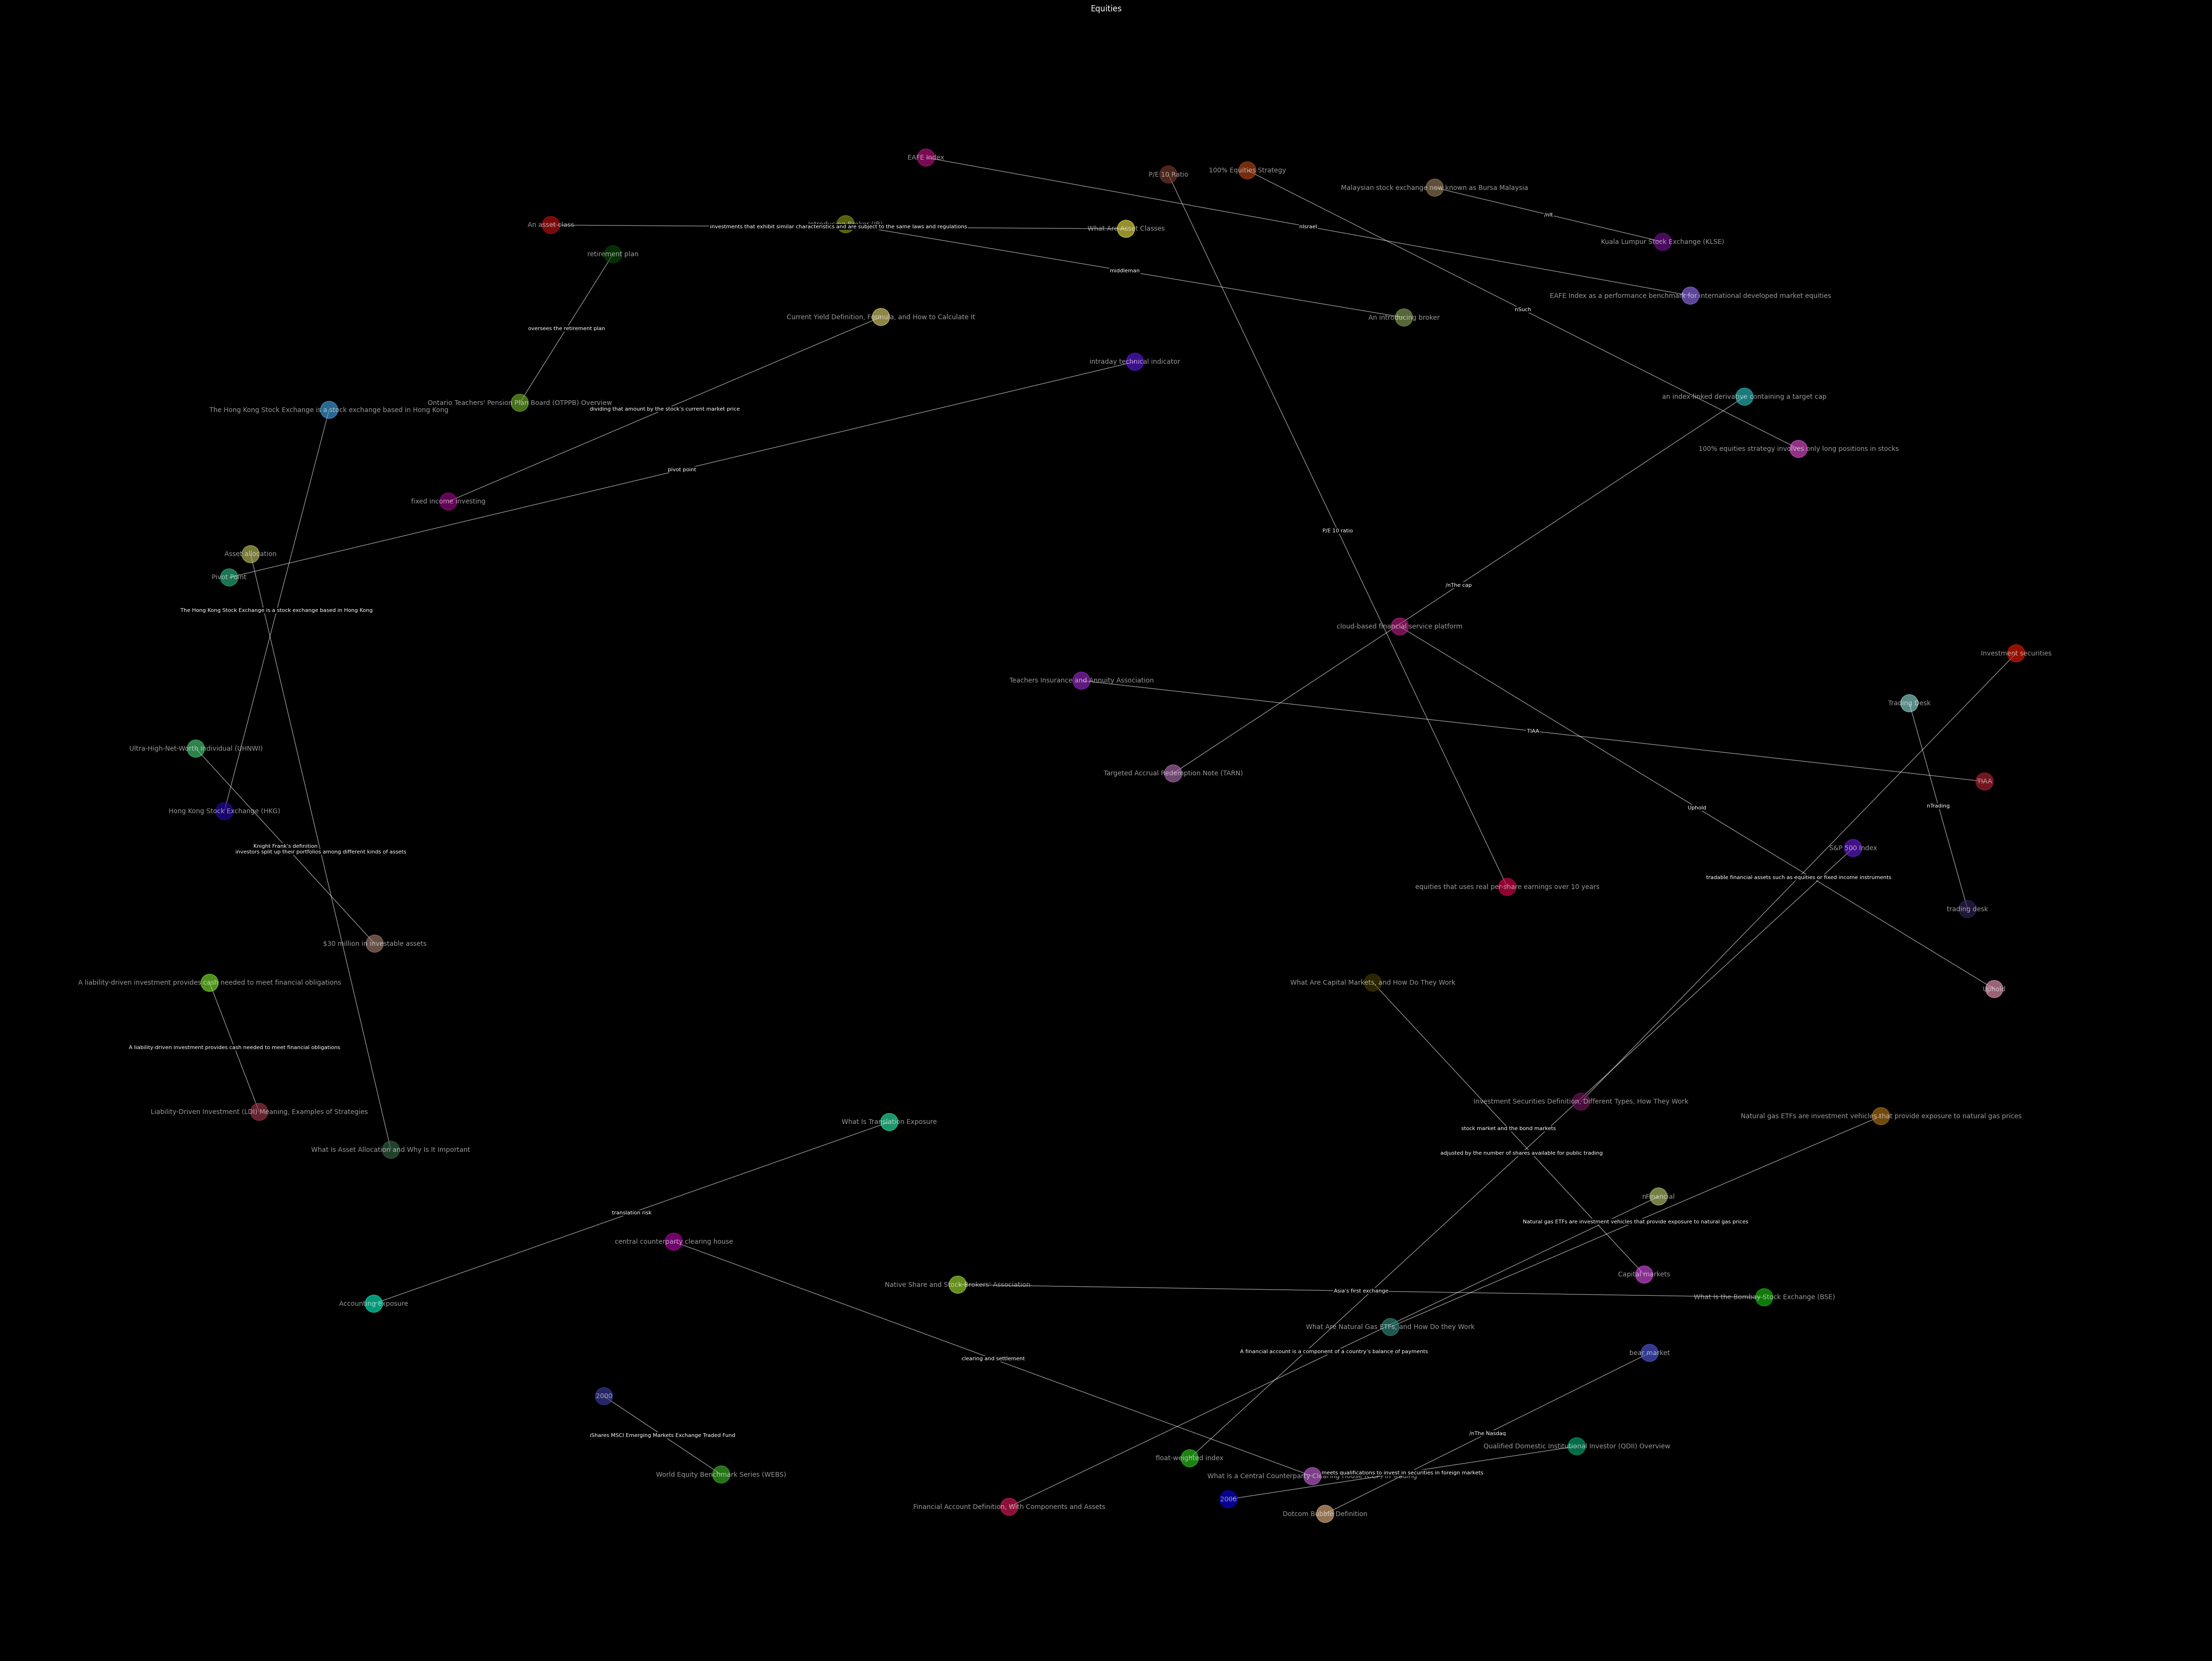

sh: xdg-open: command not found


32512

In [54]:
def random_color():
    return [random.random() for _ in range(3)]

node_colors = [random_color() for _ in range(len(G.nodes))]
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')

fig, ax = plt.subplots(figsize=(30, 20))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=node_colors, edge_color='white', alpha=0.6, ax=ax, font_color='white')

for (n1, n2), label in labels.items():
    x1, y1 = pos[n1]
    x2, y2 = pos[n2]
    x, y = (x1 + x2) / 2, (y1 + y2) / 2
    plt.text(x, y, label, fontsize=8, color='white', ha='center', va='center', bbox=dict(facecolor='black', edgecolor='none', pad=1))

plt.title(topic, color='white')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(False)


fig.patch.set_facecolor('black')
ax.set_facecolor('black')
image_path = f'{topic}.png'
plt.savefig(image_path, facecolor=fig.get_facecolor())
plt.show()
os.system(f'xdg-open {image_path}')

In [55]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
node_names = list(G.nodes())
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 56
Number of edges: 28
Ratio edges to nodes: 0.5


# Store Data in Obsidian

In [56]:
vault_path = '/Users/isha/Documents/Obsidian/KnowledgeGraphs/'

In [57]:
for file in os.listdir(vault_path):
    if file.endswith(".md"):
        os.remove(os.path.join(vault_path, file))

In [58]:
import os

for index, row in df.iterrows():
    if row['Term'] in relation_df['Head'].values:
        file_name = f"{row['Term'].replace(' ', '_').replace('/', '_').replace(':', '_')}.md"
        definition_lines = row['Definition'].split('/n')
        bullet_points = '\n'.join(f"* {line}" for line in definition_lines)
        tag = "#headWithDefinition"
        file_content = f"# {row['Term']}\n\n{bullet_points}\n\n[More Info]({row['URL']})\n\n{tag}"
        file_path = os.path.join(vault_path, file_name)
        try:
            with open(file_path, 'w') as file:
                file.write(file_content)
        except OSError as e:
            print(f"Error writing to file {file_path}: {str(e)}")


In [59]:
for tail in relation_df['Tail'].unique():
    tail_df = relation_df[relation_df['Tail'] == tail]
    content = f"# {tail}\n\n### Links to Heads\n"
    for index, row in tail_df.iterrows():
        head_file_name = row['Head'].replace(" ", "_").replace("\n", "").replace("/", "_") + ".md"
        content += f"- {row['Relation']} [[{head_file_name}|{row['Head']}]]\n"
    
    tag = "#tail" 
    content += f"\n\n{tag}"
    
    tail_file_name = tail.replace(' ', '_').replace("\n", "").replace("/", "_")
    file_path = os.path.join(vault_path, f"{tail_file_name}.md")
    try:
        with open(file_path, 'w') as file:
            file.write(content)
    except OSError as e:
        print(f"Error writing to file {file_path}: {str(e)}")
